In [1]:
import os
import json
import pickle
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from IPython.core.display import display, HTML

from datetime import datetime

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# Load the functions
import sys
sys.path.insert(1, '../src')
from preprocessing_eda import *

In [2]:
if not os.path.isfile("../data/clean/TrainData.pkl"):
    df_train.sort_values(by = "Timestamp", inplace = True)
    df_train.reset_index(drop = True, inplace = True)
    df_train.to_pickle("../data/clean/TrainData.pkl")
else:
    df_train = pd.read_pickle("../data/clean/TrainData.pkl")

if not os.path.isfile("../data/clean/TestData.pkl"):
    df_test.sort_values(by = "Timestamp", inplace = True)
    df_test.reset_index(drop = True, inplace = True)
    df_test.to_pickle("../data/clean/TestData.pkl")
else:
    df_test = pd.read_pickle("../data/clean/TestData.pkl")

In [3]:
# For the training set
if os.path.isfile("../data/clean/train_sparse_UI.npz"):
    train_sparse_UI = sparse.load_npz("../data/clean/train_sparse_UI.npz")
    
else:
    num_users_train = len(set(df_train['UserId']))
    num_products_train = len(set(df_train['ProductId']))
    train_sparse_IU, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind\
    = create_X(df_train, n=num_products_train, d=num_users_train, user_key='UserId', item_key='ProductId')  
    train_sparse_UI = train_sparse_IU.T
    sparse.save_npz("../data/clean/train_sparse_UI.npz", train_sparse_UI)

In [4]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_items):
    start = datetime.now()
    users, items, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_items = np.unique(items)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    itemS = np.random.choice(uniq_items, n_items, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(items, itemS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], items[mask])), 
                                                     shape = (max(userS)+1, max(itemS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

In [5]:
path = "../data/clean/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(train_sparse_UI, 100000, 10000)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (1025570, 226768)


In [6]:
sample_train_users, sample_train_items, sample_train_ratings = sparse.find(train_sample_sparse)

In [7]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1 
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [8]:
average_user_rating = getAverageRatings(train_sparse_UI, True)
average_item_rating = getAverageRatings(train_sparse_UI, False)

In [9]:
if os.path.isfile("../data/clean/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    train_sample_sparse_T = train_sample_sparse.T
    with open("../data/clean/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, item, rating in zip(sample_train_users, sample_train_items, sample_train_ratings):
            row = list()
            row.append(user)  #appending user index
            row.append(item) #appending item index
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "item" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)
            similar_users_indices = similar_users_indices[similar_users_indices != user]
            similar_users_ratings = train_sample_sparse[similar_users_indices, item].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([average_item_rating[item]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "item" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "item" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar items with "items"------------------#
            similar_items = cosine_similarity(train_sample_sparse_T[item], train_sample_sparse_T).ravel()
            similar_items_indices = np.argsort(-similar_items)
            similar_items_indices = similar_items_indices[similar_items_indices != item]
            similar_items_ratings = train_sample_sparse[user, similar_items_indices].toarray().ravel()
            top_similar_item_ratings = list(similar_items_ratings[similar_items_ratings != 0][:5])
            top_similar_item_ratings.extend([average_user_rating[user]]*(5-len(top_similar_item_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_item_ratings)
            
 #----------------------------------Appending "user" average, "item" average & rating of "user""item"-----------#
            row.append(average_user_rating[user])
            row.append(average_item_rating[item])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [10]:
Train_Reg = pd.read_csv("../data/clean/Train_Regression.csv", names = ["User_ind", "Item_ind", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SIR1", "SIR2", "SIR3", "SIR4", "SIR5", "User_Average", "Item_Average", "Rating"])
Train_Reg.head()

,User_ind,Item_ind,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SIR1,SIR2,SIR3,SIR4,SIR5,User_Average,Item_Average,Rating
0,500635,17,4.144044,1.0,3.428571,3.428571,3.428571,3.428571,5.000000,4.666667,4.666667,4.666667,4.666667,4.666667,3.428571,5.0
1,993665,17,4.144044,5.0,3.428571,3.428571,3.428571,3.428571,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.428571,1.0
2,83620,83,4.144044,3.8,3.800000,3.800000,3.800000,3.800000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.800000,3.0
3,648587,177,4.144044,5.0,5.000000,4.565217,4.565217,4.565217,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.565217,2.0
4,715917,177,4.144044,2.0,5.000000,4.565217,4.565217,4.565217,4.666667,4.666667,4.666667,4.666667,4.666667,4.666667,4.565217,5.0


In [11]:
print("Number of nan Values: "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values: 0


In [12]:
print("Shape of Train DataFrame: {}".format(Train_Reg.shape))

Shape of Train DataFrame: (7463, 16)


In [13]:
# For the test set
if os.path.isfile("../data/clean/test_sparse_UI.npz"):
    test_sparse_UI = sparse.load_npz("../data/clean/test_sparse_UI.npz")
    
else:
    num_users_test = len(set(df_test['UserId']))
    num_products_test = len(set(df_test['ProductId']))
    test_sparse_IU, user_mapper_test, item_mapper_test, user_inverse_mapper_test, item_inverse_mapper_test, user_ind_test, item_ind_test\
    = create_X(df_test, n=num_products_test, d=num_users_test, user_key='UserId', item_key='ProductId')  
    test_sparse_UI = test_sparse_IU.T
    sparse.save_npz("../data/clean/test_sparse_UI.npz", test_sparse_UI)

In [14]:
path = "../data/clean/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(test_sparse_UI, 50000, 5000)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (331226, 113835)


In [15]:
sample_test_users, sample_test_items, sample_test_ratings = sparse.find(test_sample_sparse)

In [16]:
if os.path.isfile("../data/clean/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    test_sample_sparse_T = test_sample_sparse.T
    train_sample_sparse_T = train_sample_sparse.T
    with open("../data/clean/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, item, rating in zip(sample_test_users, sample_test_items, sample_test_ratings):
            row = list()
            row.append(user)  #appending user index
            row.append(item) #appending item index
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "item" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)
                similar_users_indices = similar_users_indices[similar_users_indices != user]
                similar_users_ratings = train_sample_sparse[similar_users_indices, item].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([average_item_rating[item]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "item" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "item" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new item#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar items with "item"-----------------------#
            try:
                similar_items = cosine_similarity(train_sample_sparse_T[item], train_sample_sparse_T).ravel()
                similar_items_indices = np.argsort(-similar_items)
                similar_items_indices = similar_items_indices[similar_items_indices != item]
                similar_items_ratings = train_sample_sparse[user, similar_items_indices].toarray().ravel()
                top_similar_item_ratings = list(similar_items_ratings[similar_items_ratings != 0][:5])
                top_similar_item_ratings.extend([average_user_rating[user]]*(5-len(top_similar_item_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_item_ratings)
            #########Cold Start Problem, for a new user or a new item#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "item" average & rating of "user""item"----------------#
            try:        
                row.append(average_user_rating[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(average_item_rating[item])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 500 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [17]:
Test_Reg = pd.read_csv("../data/clean/Test_Regression.csv", names = ["User_ind", "Item_ind", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SIR1", "SIR2", "SIR3", "SIR4", "SIR5", "User_Average", "Item_Average", "Rating"])
Test_Reg.head()

,User_ind,Item_ind,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SIR1,SIR2,SIR3,SIR4,SIR5,User_Average,Item_Average,Rating
0,208555,92,4.144044,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,5.0
1,303329,92,4.144044,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,5.0
2,257701,225,4.144044,2.000000,2.000000,2.000000,2.000000,2.000000,5.0,5.0,5.0,5.0,5.0,5.0,2.000000,3.0
3,106988,233,4.144044,3.000000,3.000000,3.000000,3.000000,3.000000,5.0,5.0,5.0,5.0,5.0,5.0,3.000000,5.0
4,274279,487,4.144044,4.466667,4.466667,4.466667,4.466667,4.466667,5.0,5.0,5.0,5.0,5.0,5.0,4.466667,5.0


In [18]:
print("Number of nan Values: "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values: 0


In [19]:
print("Shape of Test DataFrame: {}".format(Test_Reg.shape))

Shape of Test DataFrame: (2677, 16)


### Transform data for the Surprise package

In [20]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ind', 'Item_ind', 'Rating']], reader)

trainset = data.build_full_trainset()

In [21]:
testset = list(zip(Test_Reg["User_ind"].values, Test_Reg["Item_ind"].values, Test_Reg["Rating"].values))

### Apply ML Models

We will consider two Error Metrics:

> - RMSE: Root Mean Square Error
>
> - MAPE: Mean Absolute Percentage Error. Let At be the actual value and Ft be the forecast value. The difference between At and Ft is divided by the actual value At. The absolute value of this result is summed and divided by the number of fitted points.

In [22]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [23]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    """
    Add training and test errors in the error table
    """
    global error_table

    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Use xgboost model

#### Functions for XGBoost model

In [28]:
def error_metrics(y_true, y_pred):
    """
    Calculate the error metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [25]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [26]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

#### 1. XGBoost with 13 features

[11:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.5648284610461196
MAPE = 11.610985482232516
--------------------------------------------------
TEST DATA
RMSE = 1.7678843078802287
MAPE = 52.01920583801522
--------------------------------------------------
Time Taken = 0:00:00.270407


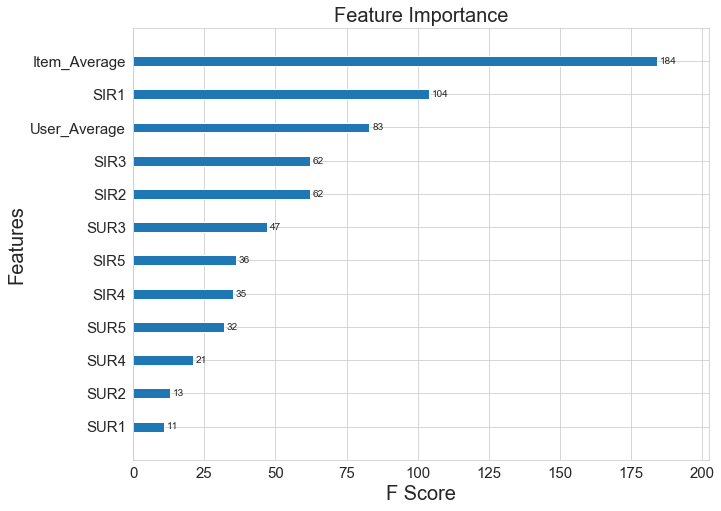

In [27]:
x_train = Train_Reg.drop(["User_ind", "Item_ind", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ind", "Item_ind", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

In [31]:
error_table

,Model,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,XGBoost_13,0.564828,11.610985,1.767884,52.019206


### Use Surprise Package

#### Functions for Surprise

In [29]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [30]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [33]:
my_seed = 1115
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())

    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)

    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

#### 2. Surprise BaselineOnly Model

##### Predicted Rating
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

##### Optimization Function
> $\large\underset{b_u, b_i}\min \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right)$

In [34]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8784440801913046
MAPE = 31.788741596955404
--------------------------------------------------
TEST DATA
RMSE = 1.2796898943946755
MAPE = 46.32837897761484
--------------------------------------------------
Time Taken = 0:00:00.093979


In [35]:
error_table

,Model,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,XGBoost_13,0.564828,11.610985,1.767884,52.019206
1,BaselineOnly,0.878444,31.788742,1.279690,46.328379


#### 3. XGBoost 13 Features + Surprise BaselineOnly Model

##### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [37]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]

In [38]:
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

[11:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.5649361842304942
MAPE = 11.744165106761859
--------------------------------------------------
TEST DATA
RMSE = 1.7738119879365648
MAPE = 52.223201154170994
--------------------------------------------------
Time Taken = 0:00:00.286349


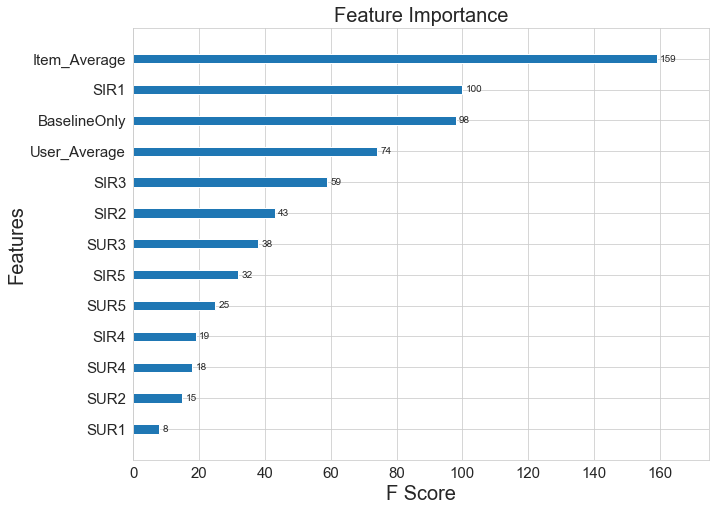

In [39]:
x_train = Train_Reg.drop(["User_ind", "Item_ind", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ind", "Item_ind", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

In [40]:
error_table

,Model,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,XGBoost_13,0.564828,11.610985,1.767884,52.019206
1,BaselineOnly,0.878444,31.788742,1.279690,46.328379
2,XGB_BSL,0.564936,11.744165,1.773812,52.223201
